# Import module

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import datetime
import os, gc

# Load data

In [2]:
codis_path = sorted([os.path.join('data', i) for i in os.listdir('data') if i.startswith('codis')])
codis_path

['data\\codis_2015.csv',
 'data\\codis_2016.csv',
 'data\\codis_2017.csv',
 'data\\codis_2018.csv',
 'data\\codis_2019.csv',
 'data\\codis_2020.csv']

In [3]:
codis_all = pd.DataFrame()
for path in codis_path:
    tmp_df = pd.read_csv(path, parse_dates=['ObsTime'])
    codis_all = pd.concat([codis_all, tmp_df], axis=0)

In [4]:
for st in [i for i in codis_all.columns if i != 'ObsTime']:
    codis_all[st] = pd.to_numeric(codis_all[st], errors='coerce')

In [5]:
codis_all.head()

,ObsTime,StnPres,Temperature,RH,WS,WD,Precp
0,2015-01-01 01:00:00,1022.3,16.0,59.0,4.9,80.0,0.0
1,2015-01-01 02:00:00,1022.6,15.5,60.0,4.6,70.0,0.0
2,2015-01-01 03:00:00,1022.8,15.3,59.0,4.3,70.0,0.0
3,2015-01-01 04:00:00,1022.9,14.8,60.0,4.1,70.0,0.0
4,2015-01-01 05:00:00,1023.4,14.4,60.0,3.5,70.0,0.0


In [6]:
codis_all.shape

(48192, 7)

# EDA

In [7]:
print(f"Data from {codis_all['ObsTime'].min()} to {codis_all['ObsTime'].max()}")

Data from 2015-01-01 01:00:00 to 2020-07-01 00:00:00


In [8]:
codis_all.describe()

,StnPres,Temperature,RH,WS,WD,Precp
count,48192.000000,48192.000000,47958.000000,48191.000000,47905.000000,45241.000000
mean,1010.236072,23.839268,73.339464,2.357793,131.336812,0.269811
std,6.968337,5.786871,12.534400,1.525939,86.489971,1.825269
min,971.100000,4.200000,23.000000,0.000000,0.000000,0.000000
25%,1005.100000,19.300000,65.000000,1.100000,70.000000,0.000000
50%,1010.300000,24.200000,74.000000,2.000000,100.000000,0.000000
75%,1015.400000,28.200000,83.000000,3.500000,180.000000,0.000000
max,1033.400000,38.500000,100.000000,14.900000,360.000000,92.900000


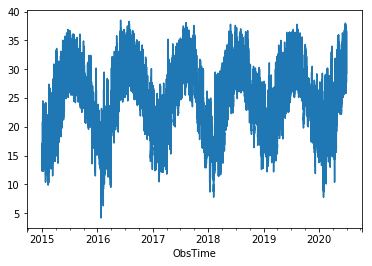

In [9]:
codis_all.set_index('ObsTime')['Temperature'].plot()

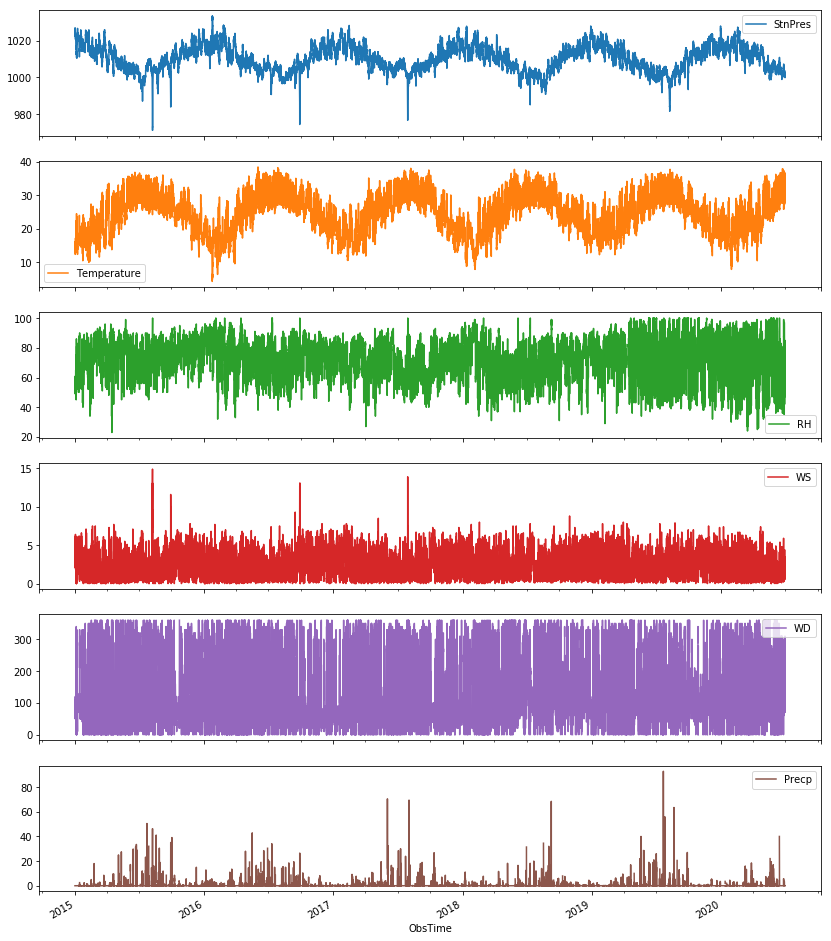

In [10]:
codis_all.set_index('ObsTime').plot(subplots=True, figsize=(14, 18))
plt.show()

In [11]:
codis_all.corr().sort_values('Temperature', ascending=False)['Temperature']

Temperature    1.000000
WD             0.322926
Precp         -0.027168
WS            -0.144922
RH            -0.406020
StnPres       -0.800750
Name: Temperature, dtype: float64

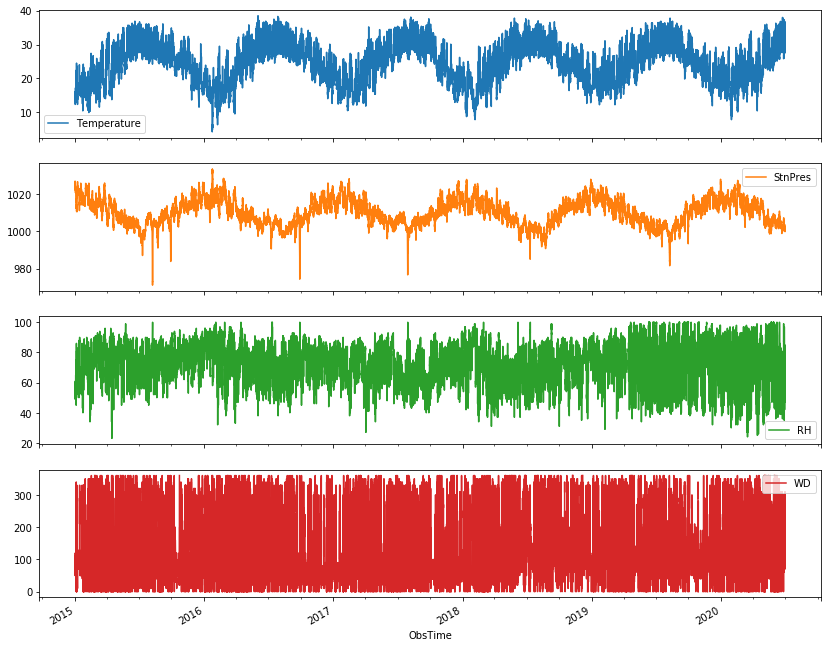

In [12]:
codis_all.set_index('ObsTime')[['Temperature', 'StnPres', 'RH', 'WD']].plot(subplots=True, figsize=(14, 12))
plt.show()

# Data split

In [13]:
trn_data = codis_all.loc[codis_all['ObsTime']<datetime.datetime(2019, 1, 1, 0), 
                       ['Temperature', 'StnPres', 'RH', 'WD']].reset_index(drop=True)

val_data = codis_all.loc[(codis_all['ObsTime']>=datetime.datetime(2019, 1, 1, 0))&(codis_all['ObsTime']<datetime.datetime(2020, 1, 1, 0)), 
                       ['Temperature', 'StnPres', 'RH', 'WD']].reset_index(drop=True)

tst_data = codis_all.loc[codis_all['ObsTime']>=datetime.datetime(2020, 1, 1, 0), 
                       ['Temperature', 'StnPres', 'RH', 'WD']].reset_index(drop=True)

trn_data.shape, val_data.shape, tst_data.shape

((35063, 4), (8760, 4), (4369, 4))

# Normalization

In [14]:
train_mean = np.nanmean(trn_data, axis=0)
train_std = np.nanstd(trn_data, axis=0)

In [15]:
train_mean, train_std

(array([  23.91364116, 1010.18490717,   72.76662008,  126.72115633]),
 array([ 5.88961001,  7.01443737, 11.32667491, 88.41121404]))

In [16]:
trn_data = (trn_data - train_mean) / train_std
val_data = (val_data - train_mean) / train_std
tst_data = (tst_data - train_mean) / train_std

In [17]:
np.nanmax(trn_data, axis=0), np.nanmin(trn_data, axis=0) 

(array([2.47662559, 3.30961581, 2.40435787, 2.63856623]),
 array([-3.34718956, -5.57206589, -4.39375373, -1.43331542]))

In [18]:
np.nanmax(val_data, axis=0), np.nanmin(val_data, axis=0) 

(array([2.35777222, 2.52551871, 2.40435787, 2.63856623]),
 array([-2.03980249, -4.08940955, -3.86403074, -1.43331542]))

In [19]:
np.nanmax(tst_data, axis=0), np.nanmin(tst_data, axis=0) 

(array([2.39173032, 2.43998085, 2.40435787, 2.63856623]),
 array([-2.73594366, -1.6658367 , -4.30546656, -1.43331542]))

# FE

In [20]:
def data_generator(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []
    
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
    
    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        
        feat = dataset[indices, :]
        label = dataset[i+target_size, 0]
        if np.isnan(label):
            continue
        if np.where(np.isnan(feat))[0].shape[0] > (feat.reshape(-1).shape[0]*1//3):
            continue
            
        feat = pd.DataFrame(feat).interpolate(limit_direction='both').values
        feat = np.where(np.isnan(feat), 0, feat)
        data.append(feat.reshape(-1))
        labels.append(label)
    return np.array(data), np.array(labels)

def create_time_steps(length):
    return list(range(-length, 0))

def show_plot(plot_data, delta, title):
    labels = ['History Temperature', 'History StnPres', 'History RH', 'History WD', 'True Future', 'Model Prediction']
    marker = ['.-', '.-', '.-', '.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0
    
    plt.title(title)
    for i, x in enumerate(plot_data):
        if i > 3:
            plt.plot(future, plot_data[i], marker[i], markersize=8, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i], marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+8)])
    plt.xlabel('Time-Step')
    return plt

In [21]:
past_history = 72
future_target = 24

x_train, y_train = data_generator(trn_data.values, 0, None, past_history, future_target)
x_valid, y_valid = data_generator(val_data.values, 0, None, past_history, future_target)
x_test, y_test = data_generator(tst_data.values, 0, None, past_history, future_target)

In [22]:
print('Train set data shape')
print(x_train.shape, y_train.shape)
print('Single window of past hidtory')
print(x_train[0][-5:])
print('Target AQI to predict')
print(y_train[0])

Train set data shape
(34967, 288) (34967,)
Single window of past hidtory
[-0.30223718 -1.5304309   0.88604296  0.02060445  0.60262541]
Target AQI to predict
-1.4794937432237905


In [23]:
print('Validation set data shape')
print(x_valid.shape, y_valid.shape)
print('Single window of past hidtory')
print(x_valid[0][-5:])
print('Target AQI to predict')
print(y_valid[0])

Validation set data shape
(8664, 288) (8664,)
Single window of past hidtory
[-0.18912936 -0.74939447  1.49906433  1.25662474 -0.52845283]
Target AQI to predict
-0.783352573797879


In [24]:
print('Test set data shape')
print(x_test.shape, y_test.shape)
print('Single window of past hidtory')
print(x_test[0][-5:])
print('Target AQI to predict')
print(y_test[0])

Test set data shape
(4273, 288) (4273,)
Single window of past hidtory
[-0.64156065 -0.73241542  1.18542549  0.3737531  -0.41534501]
Target AQI to predict
-0.7324154150593976


<module 'matplotlib.pyplot' from 'd:\\lanlearthquakeprediction\\venv_ai\\lib\\site-packages\\matplotlib\\pyplot.py'>

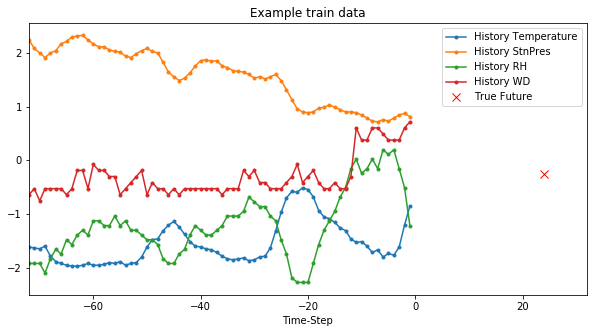

In [25]:
plt.figure(figsize=(10, 5))
show_plot([x_train[10][::4], x_train[10][1::4], x_train[10][2::4], x_train[10][3::4], y_train[10]], 
          future_target, 'Example train data')

# Build models

In [26]:
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split

## Linear regression

In [27]:
linear_reg = LinearRegression()
linear_reg.fit(x_train, y_train)
y_lr = linear_reg.predict(x_test)

Linear regression mae : 0.3693082713580492, r2 score : 0.7639220978037496


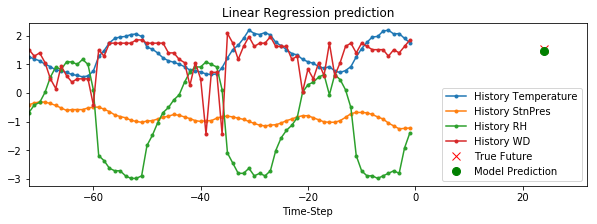

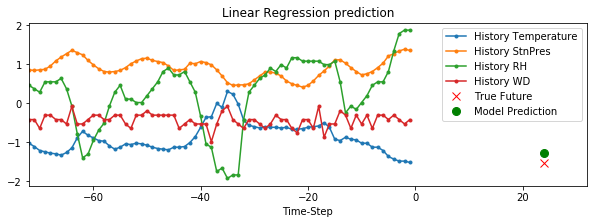

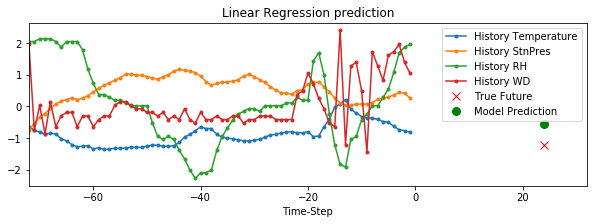

In [28]:
print(f'Linear regression mae : {mean_absolute_error(y_test, y_lr)}, r2 score : {r2_score(y_test, y_lr)}')

rnd_idx = np.random.randint(x_test.shape[0], size=3)
for x, y in zip(x_test[rnd_idx], y_test[rnd_idx]):
    plt.figure(figsize = (10,3))
    plt = show_plot([x[::4], x[1::4], x[2::4], x[3::4], y, linear_reg.predict(x.reshape(1, -1))], 
         future_target, 'Linear Regression prediction')

## SVM

In [29]:
# %%time
# svr = SVR('linear')
# svr.fit(x_train, y_train)
# y_svr = svr.predict(x_test)

In [30]:
# print(f'SVM mae : {mean_absolute_error(y_test, y_svr)}, r2 score : {r2_score(y_test, y_svr)}')

# rnd_idx = np.random.randint(x_test.shape[0], size=3)
# for x, y in zip(x_test[rnd_idx], y_test[rnd_idx]):
#     plt.figure(figsize = (10,3))
#     plt = show_plot([x[::4], x[1::4], x[2::4], x[3::4], y, svr.predict(x.reshape(1, -1))], 
#          future_target, 'SVM prediction')

# Random forest

In [31]:
%%time
rf = RandomForestRegressor(n_estimators=1000, max_depth=3, n_jobs=-1)
rf.fit(x_train, y_train)
y_rf = rf.predict(x_test)

Wall time: 1min 45s


RF mae : 0.3888259726797712, r2 score : 0.7346201895869025


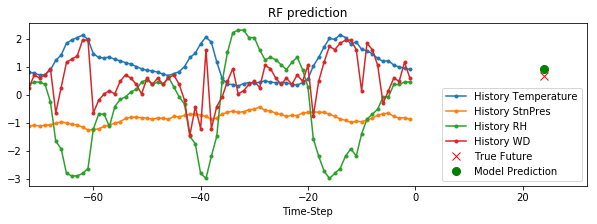

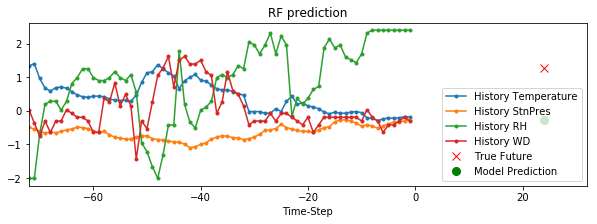

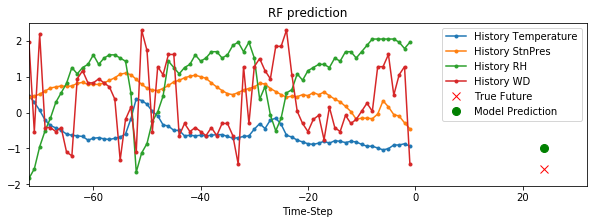

In [32]:
print(f'RF mae : {mean_absolute_error(y_test, y_rf)}, r2 score : {r2_score(y_test, y_rf)}')

rnd_idx = np.random.randint(x_test.shape[0], size=3)
for x, y in zip(x_test[rnd_idx], y_test[rnd_idx]):
    plt.figure(figsize = (10,3))
    plt = show_plot([x[::4], x[1::4], x[2::4], x[3::4], y, rf.predict(x.reshape(1, -1))], 
         future_target, 'RF prediction')

## Gradient Boost Tree

In [33]:
%%time
gb = GradientBoostingRegressor(learning_rate=0.02, 
                               n_estimators=1000,
                               max_depth=3, 
                               verbose=1, 
                               validation_fraction=0.2, 
                               n_iter_no_change=10)
gb.fit(x_train, y_train)
y_gb = gb.predict(x_test)

      Iter       Train Loss   Remaining Time 
         1           0.9628            7.66m
         2           0.9329            7.66m
         3           0.9043            7.62m
         4           0.8767            7.60m
         5           0.8502            7.59m
         6           0.8248            7.59m
         7           0.8003            7.59m
         8           0.7768            7.57m
         9           0.7542            7.57m
        10           0.7324            7.55m
        20           0.5554            7.51m
        30           0.4350            7.37m
        40           0.3527            7.25m
        50           0.2964            7.17m
        60           0.2576            7.10m
        70           0.2306            7.02m
        80           0.2118            6.95m
        90           0.1984            6.87m
       100           0.1888            6.81m
       200           0.1589            6.00m
       300           0.1519            5.20m
       40

GB mae : 0.3493273575746677, r2 score : 0.7843006461321234


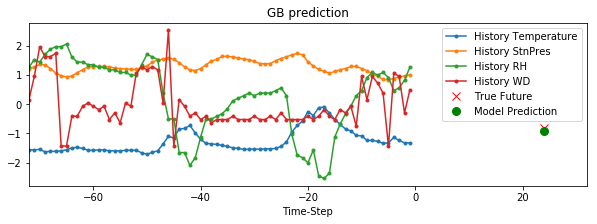

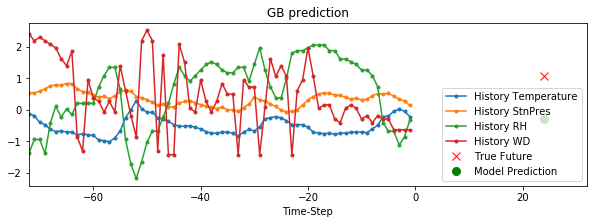

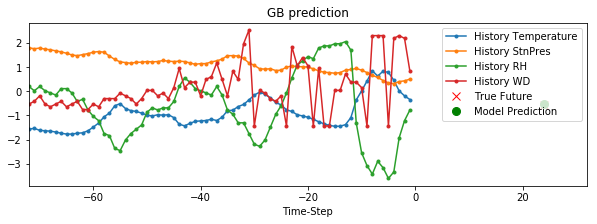

In [34]:
print(f'GB mae : {mean_absolute_error(y_test, y_gb)}, r2 score : {r2_score(y_test, y_gb)}')

rnd_idx = np.random.randint(x_test.shape[0], size=3)
for x, y in zip(x_test[rnd_idx], y_test[rnd_idx]):
    plt.figure(figsize = (10,3))
    plt = show_plot([x[::4], x[1::4], x[2::4], x[3::4], y, gb.predict(x.reshape(1, -1))], 
         future_target, 'GB prediction')

# XGB

In [35]:
import xgboost

In [36]:
%%time
xgb = xgboost.XGBRegressor(learning_rate=0.01, 
                               n_estimators = 1000,
                               max_depth = 3, 
                               n_jobs = -1)
xgb.fit(x_train, y_train, 
        eval_set=[(x_train, y_train), (x_valid, y_valid)], 
        eval_metric=['mae'], 
        early_stopping_rounds=200, verbose=100)
y_xgb = xgb.predict(x_test)

[0]	validation_0-mae:0.877876	validation_1-mae:0.818469
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 200 rounds.
[100]	validation_0-mae:0.445529	validation_1-mae:0.415349
[200]	validation_0-mae:0.332938	validation_1-mae:0.320118
[300]	validation_0-mae:0.307351	validation_1-mae:0.306919
[400]	validation_0-mae:0.299237	validation_1-mae:0.305793
[500]	validation_0-mae:0.295432	validation_1-mae:0.306168
[600]	validation_0-mae:0.293024	validation_1-mae:0.306233
Stopping. Best iteration:
[400]	validation_0-mae:0.299237	validation_1-mae:0.305793

Wall time: 42.1 s


XGB mae : 0.3596423739648955, r2 score : 0.7759604597035753


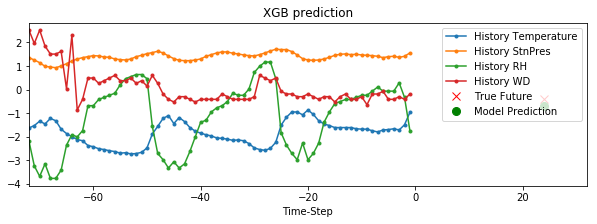

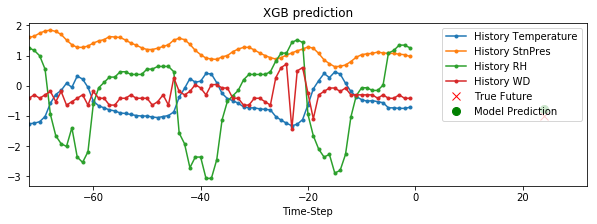

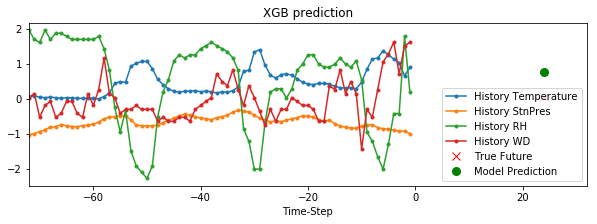

In [37]:
print(f'XGB mae : {mean_absolute_error(y_test, y_xgb)}, r2 score : {r2_score(y_test, y_xgb)}')

rnd_idx = np.random.randint(x_test.shape[0], size=3)
for x, y in zip(x_test[rnd_idx], y_test[rnd_idx]):
    plt.figure(figsize = (10,3))
    plt = show_plot([x[::4], x[1::4], x[2::4], x[3::4], y, xgb.predict(x.reshape(1, -1))], 
         future_target, 'XGB prediction')

# Plot result

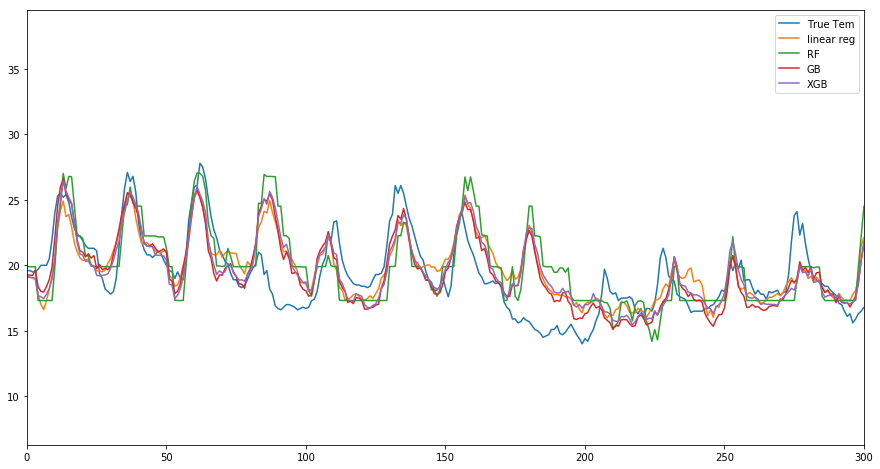

In [38]:
plt.figure(figsize=(15, 8))
plt.plot(y_test*train_std[0]+train_mean[0], label='True Tem')
plt.plot(y_lr*train_std[0]+train_mean[0], label='linear reg')
# plt.plot(y_svr*train_std[0]+train_mean[0], label='svr')
plt.plot(y_rf*train_std[0]+train_mean[0], label='RF')
plt.plot(y_gb*train_std[0]+train_mean[0], label='GB')
plt.plot(y_xgb*train_std[0]+train_mean[0], label='XGB')
plt.xlim(0, 300)
plt.legend()